# Régression linéaire par morceaux

La régression linéaire par morceaux a l'avantage de produire un modèle localement interprétable. Mais ce n'est pas évident d'estimer un tel modèle quand on ne connaît pas les morceaux par avance.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Des données artificielles

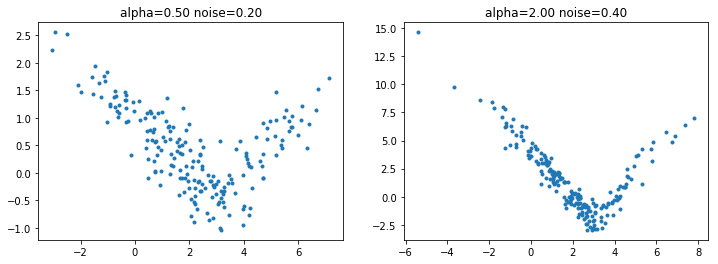

In [3]:
from numpy.random import normal
import numpy
import matplotlib.pyplot as plt

def nuage(n, alpha, noise=0.2):
    eps = normal(0, 2, (n, 2))
    X = eps[:, 0] + 2
    X1 = eps[:, 0].copy()
    X2 = eps[:, 0].copy()
    th = 1.
    X1[X1 <= th] = 0
    X2[X2 > th] = 0
    sel = numpy.zeros((n,))
    sel[X1 > th] = 1
    Y = X1 * alpha - X2 * alpha + eps[:, 1] * noise - sel * alpha * th * 2
    return X, Y

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
alpha, noise = 0.5, 0.2
X, Y = nuage(200, alpha)
ax[0].plot(X, Y, '.')
ax[0].set_title("alpha=%1.2f noise=%1.2f" % (alpha, noise));
alpha, noise = 2., 0.4
X, Y = nuage(200, alpha, noise=0.4)
ax[1].plot(X, Y, '.')
ax[1].set_title("alpha=%1.2f noise=%1.2f" % (alpha, noise));

## Quelques exemples avec un arbre de décision

La segmentation est réalisée d'abord avec un arbre de décision dont on fixe la profondeur. Chaque segment est choisi de telle sorte à minimiser l'approximation de la fonction par une constante sur chaque segment.

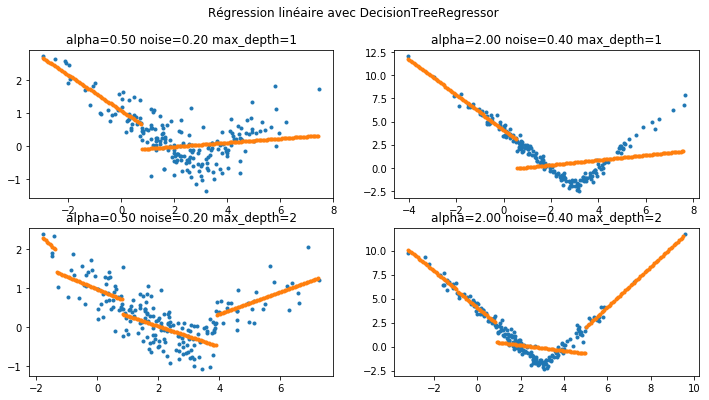

In [4]:
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor


def nuage_piecewise(n, alpha, noise=0.2, max_depth=1):
    X, Y = nuage(n, alpha, noise=noise)
    clr = PiecewiseRegressor(binner=DecisionTreeRegressor(max_depth=max_depth))
    Xm = X.reshape((len(X), 1))
    clr.fit(Xm, Y)
    mi, ma = X.min(), X.max()
    Xm = numpy.arange(0, 200) * (ma - mi) / 200 + mi
    Xm = Xm.reshape((len(Xm), 1))
    return X, Y, Xm, clr.predict(Xm)

def plot(i, j, alpha, noise, max_depth, ax):
    X, Y, XX, Z = nuage_piecewise(200, alpha, max_depth=max_depth)
    ax[i, j].plot(X, Y, '.')
    ax[i, j].plot(XX, Z, '.')
    ax[i, j].set_title("alpha=%1.2f noise=%1.2f max_depth=%d" % (
        alpha, noise, max_depth))

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

alpha, noise, max_depth = 0.5, 0.2, 1
plot(0, 0, alpha, noise, max_depth, ax)

alpha, noise, max_depth = 2., 0.4, 1
plot(0, 1, alpha, noise, max_depth, ax)

alpha, noise, max_depth = 0.5, 0.2, 2
plot(1, 0, alpha, noise, max_depth, ax)

alpha, noise, max_depth = 2., 0.4, 2
plot(1, 1, alpha, noise, max_depth, ax)

plt.suptitle("Régression linéaire avec DecisionTreeRegressor");

## Quelques exemples avec un KBinsDiscretizer

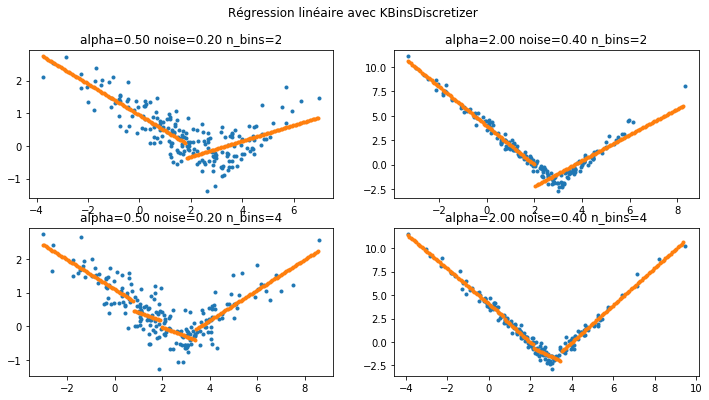

In [5]:
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.preprocessing import KBinsDiscretizer


def nuage_piecewise2(n, alpha, noise=0.2, n_bins=2):
    X, Y = nuage(n, alpha, noise=noise)
    clr = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins))
    Xm = X.reshape((len(X), 1))
    clr.fit(Xm, Y)
    mi, ma = X.min(), X.max()
    Xm = numpy.arange(0, 200) * (ma - mi) / 200 + mi
    Xm = Xm.reshape((len(Xm), 1))
    return X, Y, Xm, clr.predict(Xm)

def plot2(i, j, alpha, noise, n_bins, ax):
    X, Y, XX, Z = nuage_piecewise2(200, alpha, n_bins=n_bins)
    ax[i, j].plot(X, Y, '.')
    ax[i, j].plot(XX, Z, '.')
    ax[i, j].set_title("alpha=%1.2f noise=%1.2f n_bins=%d" % (
        alpha, noise, n_bins))

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

alpha, noise, n_bins = 0.5, 0.2, 2
plot2(0, 0, alpha, noise, n_bins, ax)

alpha, noise, n_bins = 2., 0.4, 2
plot2(0, 1, alpha, noise, n_bins, ax)

alpha, noise, n_bins = 0.5, 0.2, 4
plot2(1, 0, alpha, noise, n_bins, ax)

alpha, noise, n_bins = 2., 0.4, 4
plot2(1, 1, alpha, noise, n_bins, ax)

plt.suptitle("Régression linéaire avec KBinsDiscretizer");

C'est mieux mais ce n'est pas parfait. La classe [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) fonctionne simplement en segmentant les données mais elle ne tient pas compte de la cible.

## Arbre de décision optimisé pour la régression linéaire

L'arbre suivant reprend l'algorithme de l'arbre de décision à ceci près qu'il optimise un critère [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) en approximant le nuage de points $(X_i, y_i)$ par une fonction linéaire $y_i = X_i \beta + \epsilon_i$. Il faut néanmoins augmenter le nombre de points par feuille pour éviter quelques artefacts.

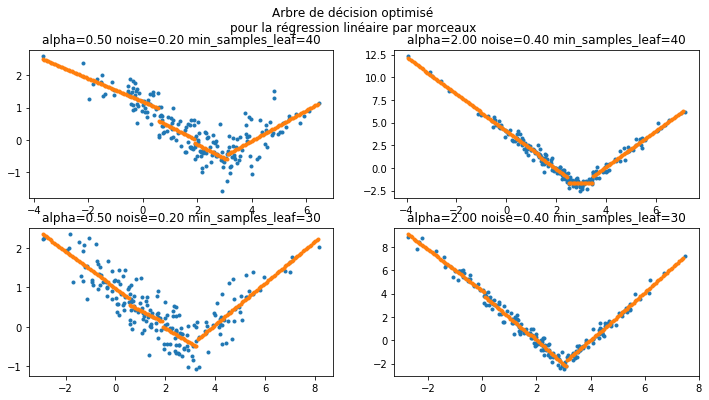

In [6]:
from mlinsights.mlmodel.piecewise_tree_regression import PiecewiseTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer


def nuage_piecewise2(n, alpha, noise=0.2, min_samples_leaf=30):
    X, Y = nuage(n, alpha, noise=noise)
    clr = PiecewiseTreeRegressor(criterion='mselin', 
                                 min_samples_leaf=min_samples_leaf)
    Xm = X.reshape((len(X), 1))
    clr.fit(Xm, Y)
    mi, ma = X.min(), X.max()
    Xm = numpy.arange(0, 200) * (ma - mi) / 200 + mi
    Xm = Xm.reshape((len(Xm), 1))
    return X, Y, Xm, clr.predict(Xm)

def plot2(i, j, alpha, noise, min_samples_leaf, ax):
    X, Y, XX, Z = nuage_piecewise2(200, alpha,
                                   min_samples_leaf=min_samples_leaf)
    ax[i, j].plot(X, Y, '.')
    ax[i, j].plot(XX, Z, '.')
    ax[i, j].set_title("alpha=%1.2f noise=%1.2f min_samples_leaf=%d" %(
        alpha, noise, min_samples_leaf))

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

alpha, noise, min_samples_leaf = 0.5, 0.2, 40
plot2(0, 0, alpha, noise, min_samples_leaf, ax)

alpha, noise, min_samples_leaf = 2., 0.4, 40
plot2(0, 1, alpha, noise, min_samples_leaf, ax)

alpha, noise, min_samples_leaf = 0.5, 0.2, 30
plot2(1, 0, alpha, noise, min_samples_leaf, ax)

alpha, noise, min_samples_leaf = 2., 0.4, 30
plot2(1, 1, alpha, noise, min_samples_leaf, ax)

plt.suptitle("Arbre de décision optimisé\npour la régression linéaire par morceaux");

Il faudrait ajouter des contraintes de continuité.